# Imports

In [ ]:
%reload_ext autoreload
%autoreload 2

import matplotlib
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statannotations.Annotator import Annotator

%run ../../setup_project.py
%run ../../generic_plot_functions.py
%run functions.py

# Load data

In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [3]:
fn = myProject.dataPath + '/results/behavior_180_EastReferenceQuadrant.csv'
res = pd.read_csv(fn)
res=res[res.valid]

In [4]:
fn = myProject.dataPath + '/results/allSessionDf_with_leverVector_and_last_cohort.csv'
allSessionDf = pd.read_csv(fn,index_col=0)
allSessionDf['light'] = allSessionDf['condition'].apply(lambda x: x.split('_')[1])
allSessionDf['cond_noLight'] = allSessionDf['condition'].apply(lambda x: x.split('_')[0])

In [5]:
allSessionDf.columns

Index(['mouse', 'session', 'condition', 'trial', 'trialNo', 'xPose', 'yPose',
       'hdPose', 'x', 'y', 'px', 'py', 'withinPathTime', 'recTime', 'speed',
       'distance', 'v0_cos', 'v0_sin', 'v1_cos', 'v1_sin', 'lv0_cos',
       'lv0_sin', 'lv1_cos', 'lv1_sin', 'mvtDirError', 'absMvtDirError',
       'shortCondition', 'light', 'path', 'v0_cos_smooth', 'v0_sin_smooth',
       'v1_cos_smooth', 'v1_sin_smooth', 'lv0_cos_smooth', 'lv0_sin_smooth',
       'lv1_cos_smooth', 'lv1_sin_smooth', 'pSpeed', 'journey', 'timesAtLever',
       'leverX', 'leverY', 'leverDistance', 'leverCenterX', 'leverCenterY',
       'bridgeCenterX', 'bridgeCenterY', 'leverAngle', 'arenaAngle',
       'bridgeAngle', 'v0', 'v1', 'v0LeverPred', 'v1LeverPred',
       'vectorToLever_v0', 'vectorToLever_v1', 'cond_noLight'],
      dtype='object')

# Main

In [6]:
histoDf = allSessionDf[allSessionDf.session.isin(useAble)].copy().reset_index(drop=True) 

#Remove NANs
histoDf = histoDf.dropna(subset = ['xPose']).copy()
#Adjust for speed?
minSpeed = 10

histoDf = histoDf[(histoDf.speed > minSpeed) ].copy() 

histoDf['light'] = histoDf['condition'].apply(lambda x: x.split('_')[1])
histoDf['cond_noLight'] = histoDf['condition'].apply(lambda x: x.split('_')[0])

In [7]:
#Get split the trials into long search path and short search path trials
for s in tqdm(res.sessionName.unique()):
    for l in res.light.unique():
        for t in res[(res.light == l)&(res.sessionName == s)].trialNo.unique():

            trial_searchPath = res[(res.light == l)&(res.sessionName == s)&(res.trialNo == t)]['searchLength'].values
            searchLengthMedian = np.nanmedian(res[(res.light == l)&(res.sessionName == s)]['searchLength'])

            if trial_searchPath <= searchLengthMedian:
                res.loc[(res.light == l)&(res.sessionName == s)&(res.trialNo == t),'searchPathSorL'] = 'shortPath'
            else:
                res.loc[(res.light == l)&(res.sessionName == s)&(res.trialNo == t),'searchPathSorL']= 'longPath'


100%|██████████| 180/180 [01:45<00:00,  1.70it/s]


In [8]:
histoDf = histoDf.merge(res, left_on=['session','trialNo','light'],right_on=['sessionName','trialNo','light'],how='left')

In [9]:
def plot_histogram_per_condition_ls_lever(ax,plotDf,light='light',colorList=['#F6BD60','#F5CAC3','#84A59D','#F28482'],legend=True,noYaxis = True,legendX = 1,legendY=0.2,ylim=0.7,xlabel='Dec. dir. error',lw=2,title='',ylabel='Density'):
    
    shortColor = '#979DAC'
    longColor = '#0466C8'

    sns.kdeplot(data=plotDf[(plotDf.cond_noLight == 'atLever')&(plotDf.light == light)&(plotDf.searchPathSorL == 'longPath')],x='mvtDirError',color=longColor,fill=None,lw=lw)
    sns.kdeplot(data=plotDf[(plotDf.cond_noLight == 'atLever')&(plotDf.light == light)&(plotDf.searchPathSorL == 'shortPath')],x='mvtDirError',color=shortColor,fill=None,lw=lw)
    sns.kdeplot(data=plotDf[(plotDf.cond_noLight == 'atLever')&(plotDf.light == light)],x='mvtDirError',fill=None,lw=lw,color=colorList[2])
    
    ax.set_title(title,fontsize=GLOBALFONTSIZE)

    
    ax.set_ylim(0,ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(xlabel, fontsize=GLOBALFONTSIZE)
    ax.set_ylabel(ylabel, fontsize=GLOBALFONTSIZE)
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    ax.set_xlim(-np.pi,np.pi)
    
    if legend:
        legend_labels = ['All trials','Short search trials','Long search trials']
        legend_colors = [colorList[2],shortColor,longColor]
        
        custom_legend = [plt.Line2D([],[],color=color, linestyle = '-',lw=lw) for color in legend_colors]
        
        ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-2, frameon=False,loc='lower center', bbox_to_anchor = (legendX,legendY))
        
    if noYaxis:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.set_yticks([])

In [10]:
def custom_stripplot_longShort(ax, inputDf, cond ='searchToLeverPath_dark',var = 'mvl',jitter=0.05, alpha=0.5,
                     ms=8, mew=1, linewidth=0.5, linestyle='--', colors=['#3f92e9','#ff5630'],ylim=1,ylabel='Mean vector length (MVL)',Circular=False,customYTicks=False,title=''):
    inputDf.replace({'short':'Short search','long':'Long search'},inplace=True)
    splitVariable = ['Short search','Long search']
    order = splitVariable
    xVal = 'splitMedianCondition'


    processDf = inputDf[inputDf.condition == cond].copy()
   
    aggregatedMVL = pd.pivot_table(data=processDf,values = var,index='sessionName',columns=xVal).reset_index().copy()

    aggMvlNumpy = aggregatedMVL.loc[:,splitVariable].values
       
       
    df = pd.DataFrame(aggMvlNumpy)

    df_x_jitter = pd.DataFrame(np.random.normal(loc=0, scale=jitter, size=df.values.shape), columns=df.columns)
    df_x_jitter += np.arange(len(df.columns))
   
   
    #Boxplot

    b = sns.boxplot(data=processDf,x = xVal, y = var, ax=ax, palette=['white'],order = splitVariable,showfliers=False,width=0.55, **boxplot_kwargs)
   
    p = processDf[xVal].unique()
   
    pairs = [(p[0],p[1])]
    annotator = Annotator(b, pairs, data=processDf,
                          x = xVal, y = var,order=splitVariable)

    annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
    annotator.apply_and_annotate()
   
    for i, col in enumerate(df):
        if colors is not None:
            color = colors[i]
        else:
            color = 'C{}'.format(i)  # Use default Matplotlib color cycle

        ax.plot(df_x_jitter[col], df[col], 'o', alpha=alpha, zorder=1, ms=ms, mew=mew, color=color)

    ax.set_xticks(range(len(df.columns)))

    ax.set_xlim(-0.5, len(df.columns) - 0.5)

    for idx in df.index:
        for i in range(0, len(df.columns), 2):
            ax.plot(df_x_jitter.loc[idx, [df.columns[i], df.columns[i + 1]]],
                    df.loc[idx, [df.columns[i], df.columns[i + 1]]],
                    color='grey', linewidth=linewidth, linestyle=linestyle, zorder=-1)
           
   
   
    ax.set_xticklabels(splitVariable,fontsize=GLOBALFONTSIZE)
   
    ax.set_ylim(0,ylim)
   
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE)
    ax.set_title(title,fontsize=GLOBALFONTSIZE)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('')
    
    ax.set_xticklabels(['Short\nsearch','Long\nsearch'])
    if customYTicks:
        ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0])
        ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0])
   
    number = len(processDf.sessionName.unique())
   
    res = scipy.stats.wilcoxon(processDf[processDf[xVal] == order[0]][var].values,processDf[processDf[xVal] == order[1]][var].values)
   
    
    ax.text(0.07,0.95, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    
    if res[1] < 0.0001:
        ax.text(0.07,0.81, f'P-value = < 0.0001',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    else:
        ax.text(0.07,0.81, f'P-value = {round(res[1],6)}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)


In [11]:
def plot_histogram_per_condition_ls_search(ax,plotDf,light='light',colorList=['#F6BD60','#F5CAC3','#84A59D','#F28482'],legend=True,noYaxis = True,legendX = 1,legendY=0.2,ylim=0.7,xlabel='Dec. dir. error',lw=2,title='',ylabel='Density'):
    
    shortColor = '#979DAC'
    longColor = '#0466C8'
      
    sns.kdeplot(data=plotDf[(plotDf.cond_noLight == 'searchToLeverPath')&(plotDf.light == light)&(plotDf.searchPathSorL == 'longPath')],x='mvtDirError',color=longColor,fill=None,lw=lw)
    sns.kdeplot(data=plotDf[(plotDf.cond_noLight == 'searchToLeverPath')&(plotDf.light == light)&(plotDf.searchPathSorL == 'shortPath')],x='mvtDirError',color=shortColor,fill=None,lw=lw)
    sns.kdeplot(data=plotDf[(plotDf.cond_noLight == 'searchToLeverPath')&(plotDf.light == light)],x='mvtDirError',fill=None,lw=lw,color=colorList[1])
    
    ax.set_title(title,fontsize=GLOBALFONTSIZE)

    ax.set_ylim(0,ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(xlabel, fontsize=GLOBALFONTSIZE)
    ax.set_ylabel(ylabel, fontsize=GLOBALFONTSIZE)
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels(["-$\pi$","0", "$\pi$"],fontsize=GLOBALFONTSIZE)
    ax.set_xlim(-np.pi,np.pi)


    if legend:
        legend_labels = ['All trials','Short search trials','Long search trials']
        legend_colors = [colorList[1],shortColor,longColor]
        
        custom_legend = [plt.Line2D([],[],color=color, linestyle = '-',lw=lw) for color in legend_colors]
        
        ax.legend(custom_legend,legend_labels,fontsize= GLOBALFONTSIZE-2, frameon=False,loc='lower center', bbox_to_anchor = (legendX,legendY))
        
    if noYaxis:
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.set_yticks([])

In [12]:
degPerBin = 10
bin_edges = np.arange(-np.pi,np.pi+degPerBin/360*2*np.pi,degPerBin/360*2*np.pi)

def get_histos_per_trial(inputDf,bin_edges = bin_edges,num_bins=36,bin_var='mvtDirError'):
    inputDf = inputDf.copy()
    # Use np.digitize to assign values to bins
    inputDf['bins'] = np.digitize(inputDf[bin_var], bin_edges)

    # Calculate and print the bin counts
    bin_counts = inputDf['bins'].value_counts().sort_index()

    # Create an array of length 1x36 with bin counts
    counts_array = np.zeros(num_bins, dtype=int)
    for bin_idx in range(1, num_bins + 1):
        count = bin_counts.get(bin_idx, 0)
        counts_array[bin_idx - 1] = count

    return counts_array

def splitShortLong(testDf):
    dfHolder = []
    for l in testDf.light.unique():
        medianSearchLength = testDf[testDf.light == l].searchLength.median()
        testDfLight = testDf[testDf.light == l].copy()
        testDfLight['splitMedianCondition'] = testDfLight.searchLength.apply(lambda x: 'short' if x < medianSearchLength else 'long')
        dfHolder.append(testDfLight)

    testDf = pd.concat(dfHolder)
    return testDf

In [13]:
def head_direction_score_from_histo(hdHisto, bins = None):
        """
        Modified method to calculate the mean direction and the mean vector length from the hd-rate histogram using already saved head-direction histogram
        
        To get valid scores (not np.nan), the sum of firing rates should be larger than 0 and there should be no np.nan in the firing_rate_head_direction_histo
        
        returns a tuple: mean_direction_rad, mean_direction_deg, mean_vector_length, peak_angle_rad, peak_rate
        """
            
        # sum up all spikes
        sum_histo = np.sum(hdHisto)
        
        # if all rates are at 0 or some at np.nan, we can't calculate these scores reliably
        if sum_histo == 0.0 or np.isnan(sum_histo):
            hd_mean_vector_length= np.nan
            hd_peak_angle_rad = np.nan
            hd_peak_rate = np.nan
            hd_mean_direction_deg = np.nan
            hd_mean_direction_rad = np.nan
            return (hd_mean_direction_rad,hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate)
        
        
        # get midth of head direction bins
        if bins == None:
            angles= [-3.05432619, -2.87979327, -2.70526034, -2.53072742, -2.35619449,
           -2.18166156, -2.00712864, -1.83259571, -1.65806279, -1.48352986,
           -1.30899694, -1.13446401, -0.95993109, -0.78539816, -0.61086524,
           -0.43633231, -0.26179939, -0.08726646,  0.08726646,  0.26179939,
            0.43633231,  0.61086524,  0.78539816,  0.95993109,  1.13446401,
            1.30899694,  1.48352986,  1.65806279,  1.83259571,  2.00712864,
            2.18166156,  2.35619449,  2.53072742,  2.70526034,  2.87979327,
            3.05432619]
        else:
            angles = bins
        
        
        # get x and y component of each angle and multiply by firing rate
        x = np.cos(angles)*hdHisto
        y = np.sin(angles)*hdHisto
                
        
        # the angle is the arctan of x divided by y
        mean_direction = np.arctan2(np.sum(y),np.sum(x))
        
        # angle of the peak
        hd_peak_angle_rad = angles[np.argmax(hdHisto)]
        hd_peak_rate = np.nanmax(hdHisto)
        
        hd_mean_direction_deg = mean_direction*360/(2*np.pi)
        hd_mean_direction_rad = mean_direction
        
        #get mean vector length
        R = np.sqrt(np.sum(x)**2+np.sum(y)**2)
        hd_mean_vector_length = R/sum_histo
        hd_variance = (1. - hd_mean_vector_length) * 180.

        return (hd_mean_direction_rad,hd_mean_direction_deg, hd_mean_vector_length, hd_peak_angle_rad, hd_peak_rate)
    
def get_combinedDf(sessionSlice,res=res,sesName = ''):
    condHolder = []
    trialHolder = []
    mvlHolder = []
    histosHolder = []
    dfHolder = []
    for cond in sessionSlice.condition.unique():
        for t in sessionSlice[sessionSlice.condition == cond].trialNo.unique():
            sliceDf = sessionSlice[(sessionSlice.condition == cond)&(sessionSlice.trialNo == t)].copy()
            histos = get_histos_per_trial(sliceDf)
            histosHolder.append(histos)

            # Step 3: Convert to complex numbers
            complex_data = np.exp(1j * sliceDf['mvtDirError'])

            # Step 4: Calculate the mean vector
            mean_vector = np.mean(complex_data)

            # Step 5: Calculate the mean vector length
            mean_vector_length = np.abs(mean_vector)

            condHolder.append(cond)
            trialHolder.append(t)
            mvlHolder.append(mean_vector_length)

    histosDf = pd.DataFrame(histosHolder,columns=[f'bin_{i}' for i in range(1,37)])

    combinedDf = pd.DataFrame({'condition':condHolder,'trialNo':trialHolder,'mvl':mvlHolder})
    combinedDf['sessionName'] = sesName
    combinedDf['light'] = combinedDf.condition.apply(lambda x: x.split('_')[1])
    combinedDf = pd.merge(combinedDf,res,how='left',on=['sessionName','trialNo','light'])

    combinedDf = pd.concat([combinedDf,histosDf],axis=1)
    combinedDf = combinedDf[combinedDf.valid == True]
    return combinedDf

def getDfBySesName(sessionName):
    inputDf = allSessionDf.copy() 
    sessionSlice = inputDf[inputDf.session == sessionName].reset_index()
    sessionSlice = sessionSlice[(sessionSlice.speed > 10)] #&(sessionSlice.speed < 40)

    combinedDf = get_combinedDf(sessionSlice.copy(),res=res.copy(),sesName = sessionName).copy()

    combinedDf.insert(0,'sumOfHistos',np.nansum(combinedDf.iloc[:,-36:].values,axis=1))

    return combinedDf

def getStatsMvlSearchLongShort():
    condList = ['searchToLeverPath_dark', 'atLever_dark']
    
    sesHolder = []
    shortHolder = []
    longHolder = []
    condHolder = []

    for sesName in tqdm(useAble):
        testDf = splitShortLong(getDfBySesName(sesName))

        for cond in condList:
            shortDf = testDf[testDf.splitMedianCondition == 'short']
            longDf = testDf[testDf.splitMedianCondition == 'long']

            shortHistos = np.nansum(shortDf[shortDf.condition==cond].iloc[:,-37:-1], axis=0)
            longHistos = np.nansum(longDf[longDf.condition==cond].iloc[:,-37:-1], axis=0)

            _, _, mvlShort, _, _ = head_direction_score_from_histo(shortHistos)
            _, _, mvlLong, _, _ = head_direction_score_from_histo(longHistos)

            sesHolder.append(sesName)
            shortHolder.append(mvlShort)
            longHolder.append(mvlLong)
            condHolder.append(cond)

    mvlDf = pd.DataFrame({'sessionName':sesHolder, 'short':shortHolder, 'long':longHolder, 'condition':condHolder})
    mvlDfCond = mvlDf.melt(id_vars=['sessionName', 'condition'], value_vars=['short', 'long'], var_name='splitMedianCondition', value_name='mvl')
    return mvlDfCond

In [14]:
mvlDfCond = getStatsMvlSearchLongShort()

100%|██████████| 24/24 [02:44<00:00,  6.87s/it]


# Make figure

In [15]:
mvlDfCond['mouse'] = mvlDfCond['sessionName'].apply(lambda x: x.split('-')[0])

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Short search vs. Long search: Wilcoxon test (paired samples), P_val:5.960e-07 Stat=3.000e+00


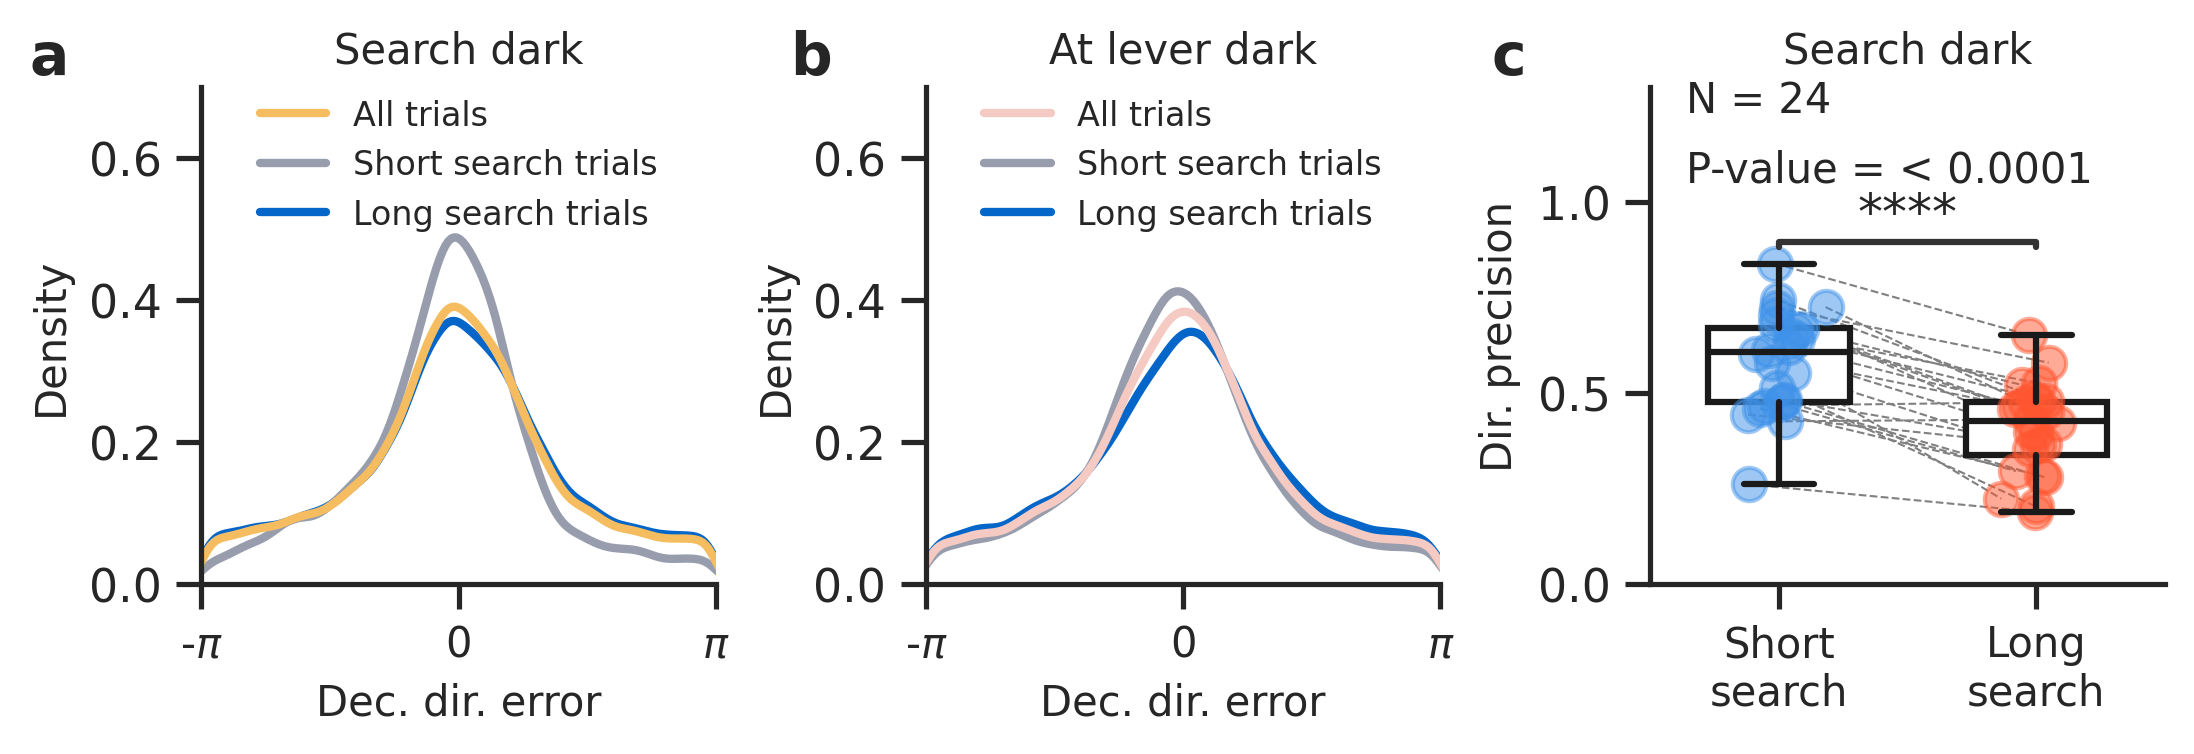

In [16]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
nrows = 1
ncols = 3
colSize = 2.4
rowSize = 2.4
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

#Data Used For Making the Plot
sns.set_theme(style = 'ticks')

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
gs = GridSpec(nrows,ncols,figure = fig)

# NOTE SEARCH
ax = fig.add_subplot(gs[0,0])
plot_histogram_per_condition_ls_search(ax,histoDf,'dark',colorList=['#F28482','#F6BD60','#F5CAC3','#84A59D'],noYaxis=False,legendX = 0.5,legendY=0.65)
ax.set_title('Search dark',fontsize=GLOBALFONTSIZE)

# NOTE LEVER
ax = fig.add_subplot(gs[0,1])
plot_histogram_per_condition_ls_lever(ax,histoDf,'dark',colorList=['#F28482','#F6BD60','#F5CAC3','#84A59D'],noYaxis=False,legendX = 0.5,legendY=0.65)
ax.set_title('At lever dark',fontsize=GLOBALFONTSIZE)


# NOTE Add stats
ax = fig.add_subplot(gs[0,2])
custom_stripplot_longShort(ax,mvlDfCond,cond ='searchToLeverPath_dark',var = 'mvl',ylabel='Dir. precision',title='Search dark',ylim=1.3)


gs1 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:,:])
#***********************************#
ax0 = fig.add_subplot(gs1[:,:])

#Add figure legend
add_text(ax0,0,1,'a',fw='900')
add_text(ax0,0.36,1,'b',fw='900')
add_text(ax0,0.69,1,'c',fw='900')

ax0.axis('off')
###


plt.savefig('../../Output/Sup_Figure10.pdf', bbox_inches='tight', dpi=300)